## Cropping PSF

Reduce the size of the PSF so as to minimize any out of memory errors when performing RL deconvolution. 
Using the idea from lls_dd: https://github.com/VolkerH/Lattice_Lightsheet_Deskew_Deconv/blob/master/examples/find_PSF_support.ipynb 

where a threshold is applied and psf cropped based on the generated mask

In [1]:
import numpy as np
import math 
from skimage.io import imread
import pyclesperanto_prototype as cle 


psf = imread("../sample_data/psfs/zeiss_simulated/488.tif")

dzpsf=0.3
dxpsf=0.1449922


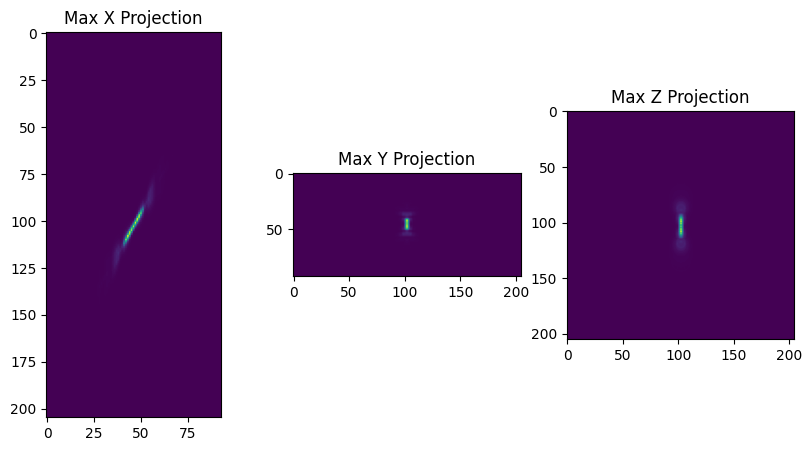

In [2]:
#Define a function for generating montages of the projection in different axes
def plot_montage_projections(img):
     
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1,3, figsize=(10,5))

    ax[0].imshow(cle.maximum_x_projection(img))
    ax[0].set_title("Max X Projection")
    ax[1].imshow(cle.maximum_y_projection(img))
    ax[1].set_title("Max Y Projection")
    ax[2].imshow(cle.maximum_z_projection(img))
    ax[2].set_title("Max Z Projection")
    return

#Montage of PSF image
plot_montage_projections(psf)

Note that there is a lot of empty space. Lets figure out what happens if we apply a really small threshold based on percentage of max intensity value

0.4180338
4.180338084697724e-06


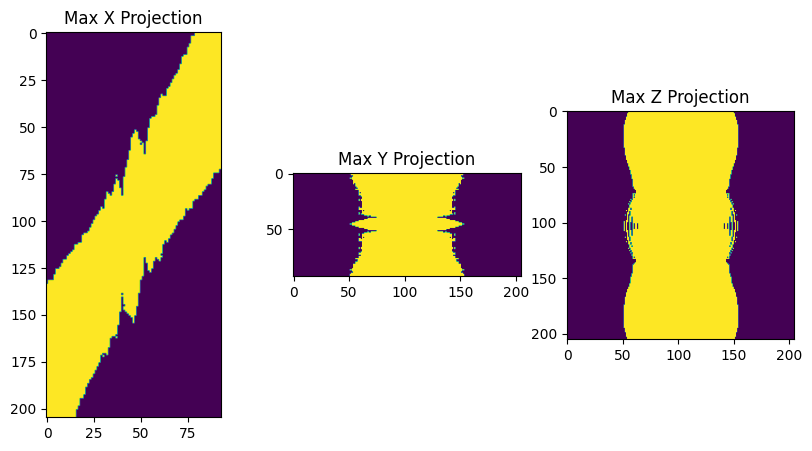

In [60]:
psf_max = psf.max()
print(psf_max)
threshold = 1e-5
psf_threshold = psf_max * 0.00001
print(psf_threshold)
psf_filtered = psf>psf_threshold
plot_montage_projections(psf_filtered)

What if we apply a threshold of 0.003*(max intensity of psf)

0.001254101425409317


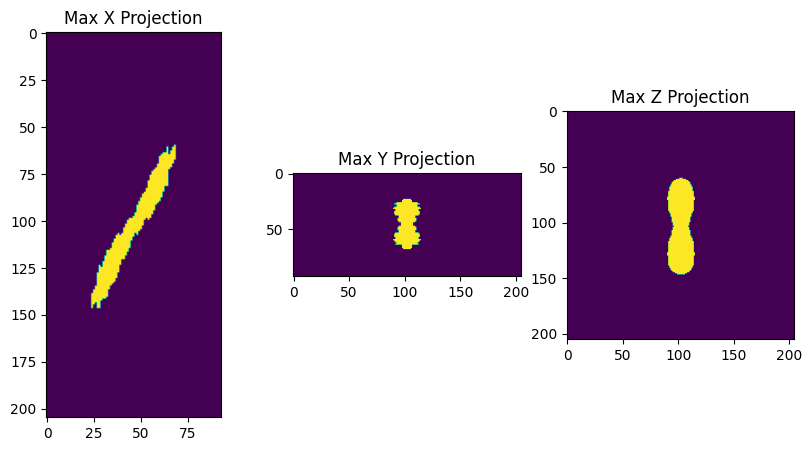

In [63]:
threshold = 3e-3
psf_threshold = psf_max * threshold
print(psf_threshold)
psf_filtered = psf>psf_threshold
plot_montage_projections(psf_filtered)

24 60 90
68 146 114
[44 86 24]
(44, 86, 24)


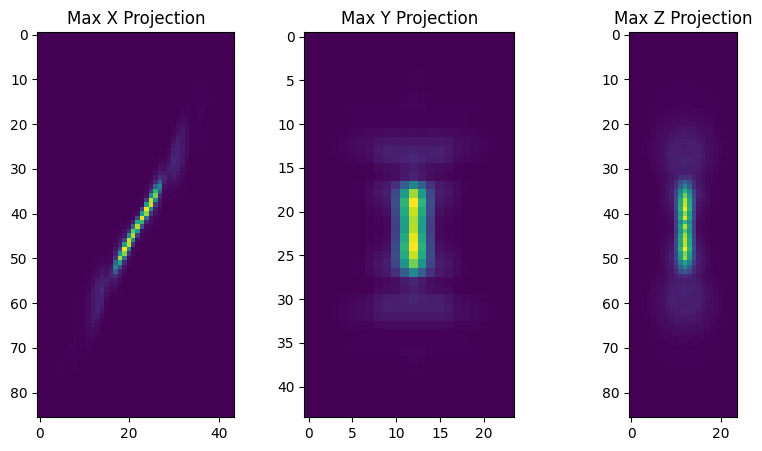

In [64]:
min_z,min_y,min_x = np.min(np.where(psf_filtered),axis = 1)
max_z,max_y,max_x = np.max(np.where(psf_filtered),axis = 1)


print(min_z,min_y,min_x)
print(max_z,max_y,max_x)

psf_shape = np.max(np.where(psf_filtered),axis = 1) - np.min(np.where(psf_filtered),axis = 1)
print(psf_shape)

psf_crop = psf[min_z:max_z,min_y:max_y,min_x:max_x]
print(psf_crop.shape)
plot_montage_projections(psf_crop)

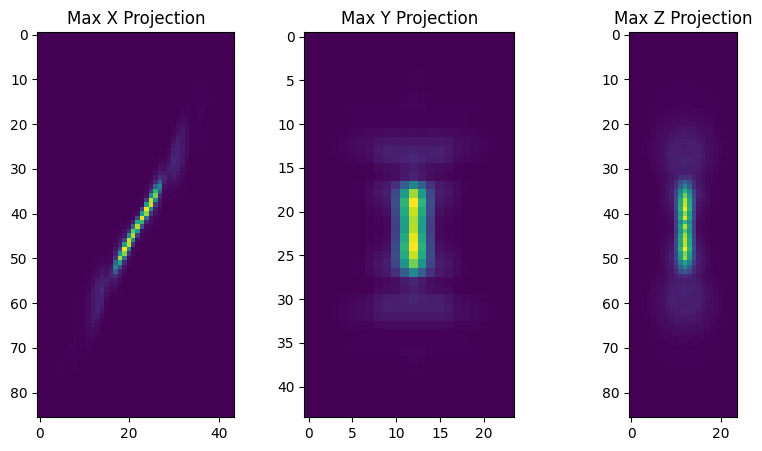

In [3]:
def crop_psf(psf_img:np.ndarray,threshold:float):
    psf_max = psf_img.max()
    psf_threshold = psf_max * threshold
    #print(psf_threshold)
    psf_filtered = psf>psf_threshold
    #Get dimensions for min and max, where psf is greater than threshold
    min_z,min_y,min_x = np.min(np.where(psf_filtered),axis = 1)
    max_z,max_y,max_x = np.max(np.where(psf_filtered),axis = 1)
    psf_crop = psf_img[min_z:max_z,min_y:max_y,min_x:max_x]
    return psf_crop

cropped = crop_psf(psf,threshold=3e-3)
plot_montage_projections(cropped)

In [51]:
#Use RedLionfish library to crop PSF
from RedLionfishDeconv.helperfunctions import change3DSizeTo
psf_crop_RL = change3DSizeTo(psf,psf_crop.shape)

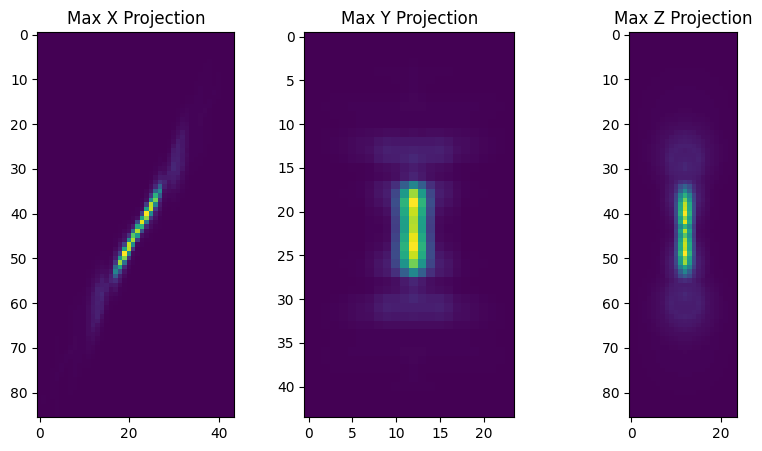

In [52]:
plot_montage_projections(psf_crop_RL)